# Machine Learning for Complete Intersection Calabi-Yau Manifolds

After the preanalysis and the **feature selection**, we no proceed with the ML analysis using different algorithms to evaluate the best predictions for the **Hodge numbers** of CICY 3-folds. We first print debug information on the system and then load the previously generated datasets. We then move to the analysis using _Scikit-learn_ as reference library. In particular we use:

- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to have a starting point,
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) to check the difference from the linear model using a **L1** regularization,
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to implement **L2** regularization to the linear model,
- [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to see whether **L1** and **L2** can be implemented together,
- [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) to implement **support vectors** with a linear kernel,
- [SVR (with Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to introduce a kernel function,
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to use forests of **decision trees** for the predictions,
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) to boost single decision trees using gradient descent (in this case we will also study the **learning curve**).

In the case of the **support vector machine** with Gaussian kernel we will also compare the results with [_Bull et al._](https://arxiv.org/abs/1806.03121)): we will check that the results are reproducible and that feature engineering can help in improving the predictions.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.10-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3239 MHz (max: 3800 MHz)
Available RAM memory:        9647 MB (tot: 15758 MB)


For future use, we establish early in the notebook the number of maximum jobs that every algorithm can take concurrently. Thus, if we want to run parallel notebooks with different jobs, we will not encounter issues.

In [2]:
#n_jobs = int(InfoOS().threads) #---------- very intensive but faster
n_jobs = int(InfoOS().threads / 2) #------ still fast enough but less intensive (only 50% of available threads are occupied)
#n_jobs = int(InfoOS().threads / 4) #------ slower

We then print information on the current GPU setup (if available):

In [3]:
!nvidia-smi

Thu May  7 22:58:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   42C    P8    N/A /  N/A |      5MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [4]:
import sys
import json

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Scikit-optimize version: {}'    .format(sko.__version__))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.4
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [5]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs
OUT_DIR  = 'output' #--------------------------------------------- directory of outputs, data, csv files, etc.

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '_analysis.h5' #------------------------------ full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

We also create a log file to store debug and related information:

In [6]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '_ml.log'
                       ) #----------------------------------------------------- path to the log file
log = create_logfile(path_to_log,
                     name=DB_NAME + '_ml',
                     level=logging.DEBUG
                    ) #-------------------------------------------------------- create a log file and a log session

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-05-07 22:58:53,024: INFO ==> New logging session started. Log is at ./log/original/cicy3o_ml.log.


## Loading the Dataset

We first load the dataset we built during the preanalysis.

In [7]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    log.debug('Database loaded.')
    log.info('Shape is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    log.error('Cannot load database from {}!'.format(DB_PATH))

2020-05-07 22:58:53,328: DEBUG ==> Database loaded.
2020-05-07 22:58:53,329: INFO ==> Shape is 7851 rows x 7 columns.


We print the `dtypes` and the name of the keys inside the dataframe as a reference:

In [8]:
df.dtypes

h11            int16
h21            int16
num_cp          int8
dim_cp        object
dim_h0_amb    object
matrix        object
pca           object
dtype: object

## Dense Format Extraction

We now extract the needed features from the sparse format in which they are stores. We also contextually build the feature matrices and the labels vectors needed in the analisis.

In [9]:
from mltools.libtransformer import ExtractTensor

# extract the labels
h11        = df['h11'].values
h21        = df['h21'].values

# extract the scalar feature
num_cp     = np.reshape(df['num_cp'].values, (-1,1)) # num_cp needs to be reshaped because it is a single feature

# extract the vector features
dim_cp     = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_cp']))
dim_h0_amb = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_h0_amb']))

# extract the tensor features
matrix     = np.array(ExtractTensor(flatten=True).fit_transform(df['matrix']))
pca        = np.array(ExtractTensor(flatten=True).fit_transform(df['pca']))

# build the feature engineered sets
feat_h11_nopca = np.c_[num_cp, dim_cp]
feat_h21_nopca = np.c_[num_cp, dim_cp, dim_h0_amb]

feat_h11_pca   = np.c_[feat_h11_nopca, pca]
feat_h21_pca   = np.c_[feat_h21_nopca, pca]

## Training and Validation Strategy

We now define the validation strategy and split the dataset into training, validation and test sets.

We will take out 10% of the dataset to be our **test set**. For the remaining 90% of the dataset, we will use cross-validation with 9 splits (using **KFold** splits) throughout the notebook. At the end of the day we therefore use 10% of the samples as test set, 10% as validation (in 9 folds) and effectively 80% for training.

Apart from the case of linear regression, we use Bayesan optimization (from the [_Scikit-optimize_](https://scikit-optimize.github.io/stable/index.html) library) of the hyperparameters as it helps in finding a "direction" in the procedure (as opposed to a random search) and avoids useless grid searches which for large hyperparameter spaces are unfeasible. We use a **custom scoring** function in order to find the best hyperparameters: since we ultimately want to predict an integer number, we round the results and take the **accuracy of the prediction** as a valid score (instead of using the mean squared error).

In [10]:
from sklearn.model_selection import train_test_split, KFold

# define the cross-validation splits
cv = KFold(n_splits=9, shuffle=False)

# divide into training and test sets
matrix_train, matrix_test, \
num_cp_train, num_cp_test, \
feat_h11_nopca_train, feat_h11_nopca_test, \
feat_h21_nopca_train, feat_h21_nopca_test, \
feat_h11_pca_train, feat_h11_pca_test, \
feat_h21_pca_train, feat_h21_pca_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(matrix, num_cp, feat_h11_nopca, feat_h21_nopca, feat_h11_pca, feat_h21_nopca, h11, h21,
                                       test_size=0.1,
                                       shuffle=False
                                      )

log.debug('Train set size: {:d}'.format(np.shape(matrix_train)[0]))
log.debug('Test set size: {:d}'.format(np.shape(matrix_test)[0]))

2020-05-07 22:58:54,813: DEBUG ==> Train set size: 7065
2020-05-07 22:58:54,814: DEBUG ==> Test set size: 786


In the analysis that follows we will then study the accuracy of the algorithms both on validation and test sets and we will plot the predictions made by each algorithm. We will also clearly print the best fitting hyperparameters.

In [11]:
def pretty(dct, indent=True):
    '''
    Pretty print the dictionary of best parameters.
    
    Required argument:
        dct:    the dictionary to pretty print.
        
    Optional argument:
        indent: whether to indent the printed output.
    '''
    
    for key, value in dct.items():
        if indent:
            print('    {} = {}'.format(key, value))
        else:
            print('{} = {}'.format(key, value))

We also provide a way to visualise the predictions by comparing the predictions as function of a (scalar) base feature (e.g.: `num_cp`) with respect to the ground truth:

In [12]:
def get_counts(base_feature, label):
    '''
    Returns unique values and counts of the label as a function of the base_feature.
    
    Required arguments:
        base_feature: the feature considered as base for the comparison,
        label:        the label we are interested in comparing.
    
    Yields:
        [ unique value of base_feature, unique value of label, count ].
    '''
    
    for n in np.sort(np.unique(base_feature)):
        uniques, counts = np.unique(label[np.argwhere(base_feature == n)[:,0]], return_counts=True)
        
        for u, c in np.c_[uniques, counts]:
            yield [n, u, c]

Notice that this kind of comparison is technically meaningful only when the predictions are made by the `base_feature` itself (e.g.: when training and predicting starting from `num_cp`). However we would like to show the distribution of the predicted labels as a function of a scalar feature "as representative" of the tensor-like feature on which the algorithms was trained.

## [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

We now consider the simplest algorithm in the analysis. We will perform linear regression on the data and evaluate the performace: the cost function is the simple **mean squared error** $J(\theta) = \frac{\vert\vert y - X \theta^T \vert\vert^2}{2 N}$. In this case the number of hyperparameters is very small and we can use a **grid search** to explore the entire optimization space. Specifically we will focus on:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$.

2020-05-07 23:18:07,002: INFO ==> Trainining linear regression...



MATRIX


Best parameters for h11:

    fit_intercept = 1
    normalize = 1

Accuracy of the cross-validation: 51.069% ± 1.519%
Accuracy of the predictions: 48.728%

Best parameters for h21:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 11.253% ± 0.972%
Accuracy of the predictions: 9.160%


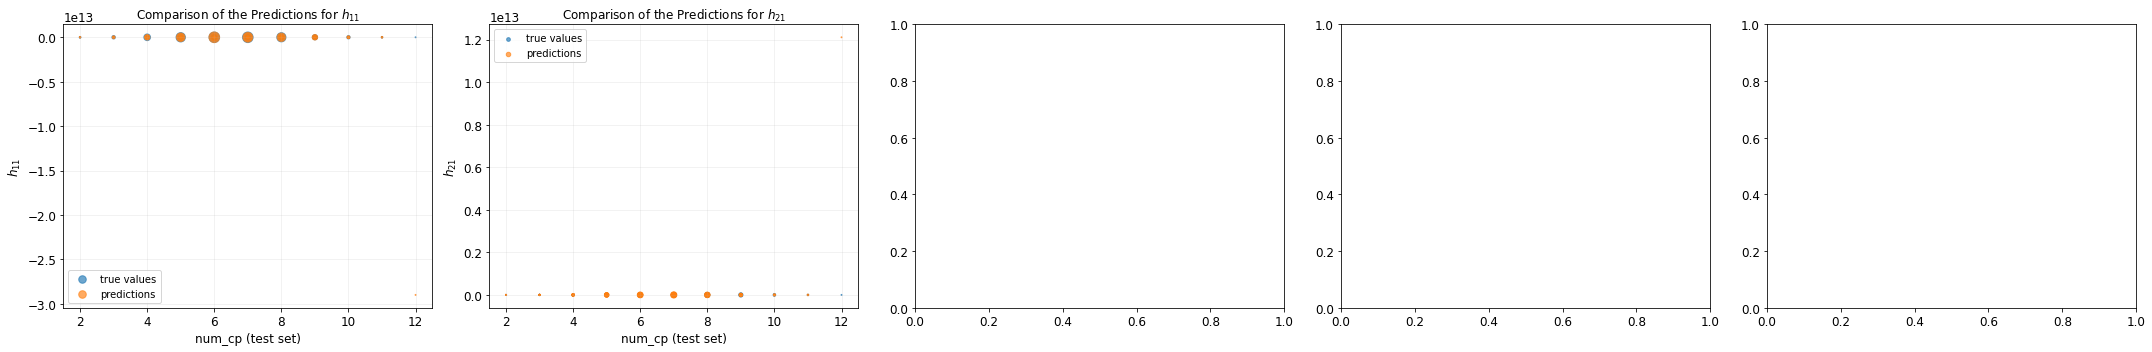

2020-05-07 23:18:11,379: DEBUG ==> Plot saved to ./img/original/lin_reg_mat_error.pdf.
2020-05-07 23:18:11,384: DEBUG ==> Predictions have been saved to ./output/original/lin_reg_mat_predictions.json.



NUM_CP


Best parameters for h11:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 61.812% ± 1.082%
Accuracy of the predictions: 63.232%

Best parameters for h21:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 8.648% ± 0.998%
Accuracy of the predictions: 8.397%


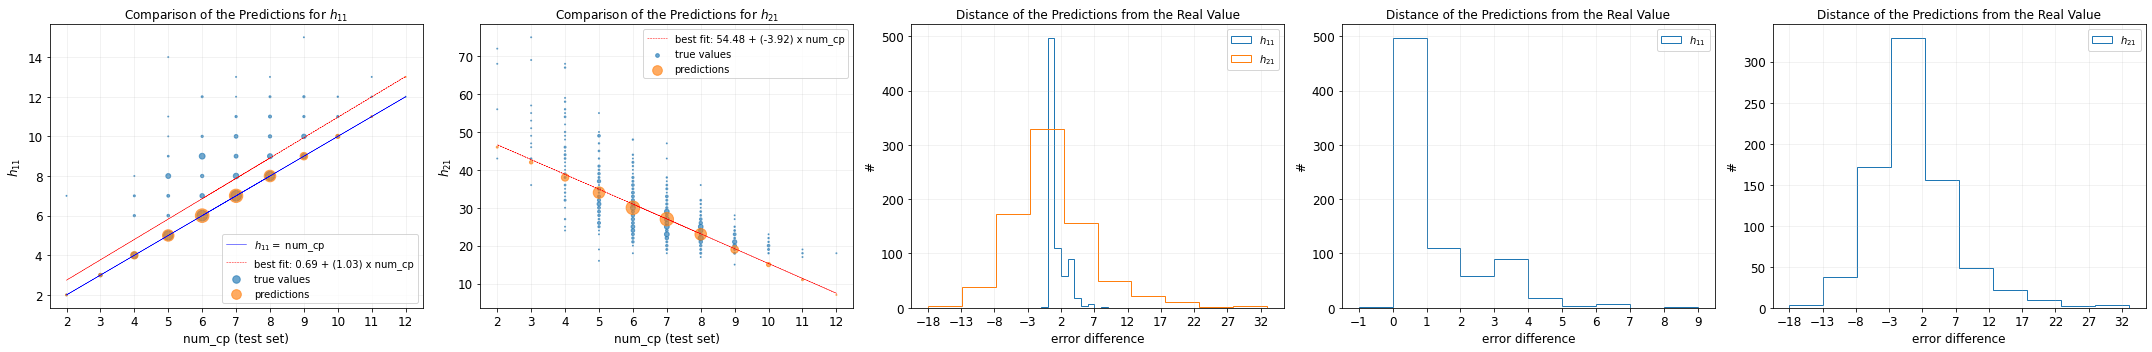

2020-05-07 23:18:12,744: DEBUG ==> Plot saved to ./img/original/lin_reg_num_cp_error.pdf.
2020-05-07 23:18:12,749: DEBUG ==> Predictions have been saved to ./output/original/lin_reg_num_cp_predictions.json.



ENGINEERED FEATURES ONLY


Best parameters for h11:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 52.654% ± 1.359%
Accuracy of the predictions: 52.036%

Best parameters for h21:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 18.217% ± 1.263%
Accuracy of the predictions: 19.338%


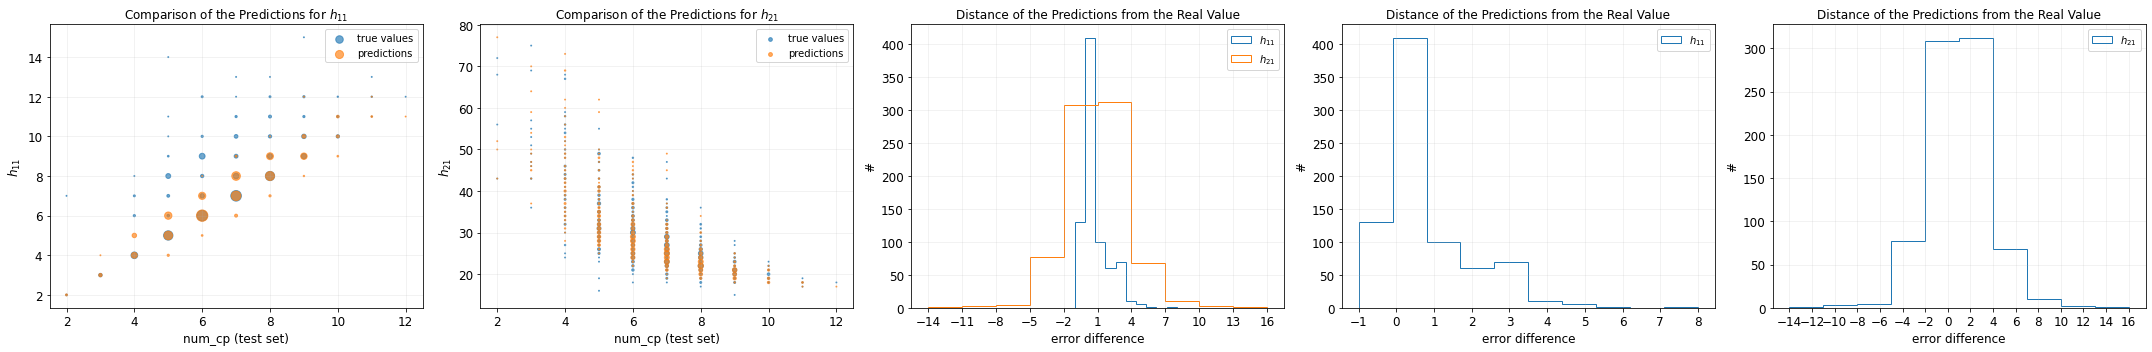

2020-05-07 23:18:14,464: DEBUG ==> Plot saved to ./img/original/lin_reg_nopca_error.pdf.
2020-05-07 23:18:14,469: DEBUG ==> Predictions have been saved to ./output/original/lin_reg_nopca_predictions.json.



ENGINEERED FEATURES AND PCA


Best parameters for h11:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 52.385% ± 1.130%
Accuracy of the predictions: 51.781%

Best parameters for h21:

    fit_intercept = 1
    normalize = 0

Accuracy of the cross-validation: 18.217% ± 1.263%
Accuracy of the predictions: 19.338%


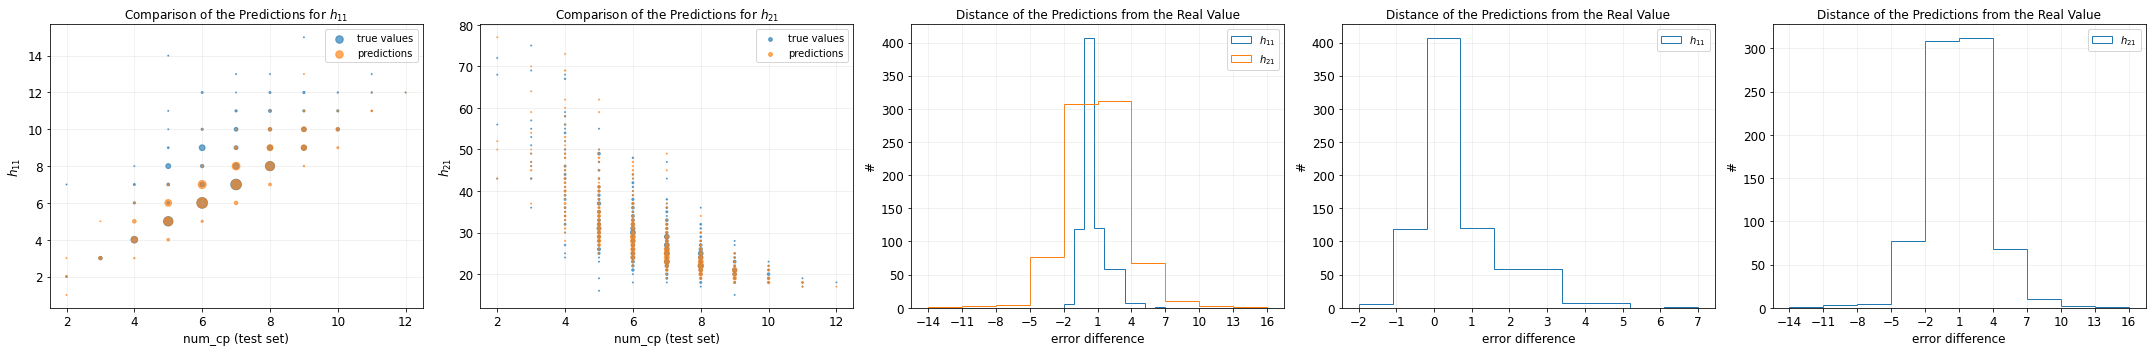

2020-05-07 23:18:16,809: DEBUG ==> Plot saved to ./img/original/lin_reg_pca_error.pdf.
2020-05-07 23:18:16,813: DEBUG ==> Predictions have been saved to ./output/original/lin_reg_pca_predictions.json.


In [22]:
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from mltools.libscore        import accuracy, Score, ViewCV
from mltools.libplot         import Plot

log.info('Trainining linear regression...')

rounding      = np.floor #------------------------------------------------ choose a rounding function
search_params = {'fit_intercept': [0, 1],
                 'normalize':     [0, 1]
                } #------------------------------------------------------- define the hyperparameter optimization space
estimator     = GridSearchCV(LinearRegression(), #------------------------ choose the base estimator
                             param_grid=search_params,
                             scoring=make_scorer(accuracy,
                                                 greater_is_better=True,
                                                 rounding=rounding
                                                ), #---------------------- create a custom scoring function (use accuracy after rounding)
                             n_jobs=n_jobs,
                             refit=True,
                             cv=cv
                            )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

# plot.hist2D(pred_score_h11.error(),
#             axis=2,
#             title='Distance of the Predictions from the Real Value',
#             legend='$h_{11}$',
#             xlabel='error difference',
#             ylabel='#',
#             binstep=5
#            )
# plot.hist2D(pred_score_h21.error(),
#             axis=2,
#             title='Distance of the Predictions from the Real Value',
#             legend='$h_{21}$',
#             xlabel='error difference',
#             ylabel='#',
#             binstep=5
#            )

# plot.hist2D(pred_score_h11.error(),
#             axis=3,
#             title='Distance of the Predictions from the Real Value',
#             legend='$h_{11}$',
#             xlabel='error difference',
#             ylabel='#',
#             binstep=1
#            )
#
# plot.hist2D(pred_score_h21.error(),
#             axis=4,
#             title='Distance of the Predictions from the Real Value',
#             legend='$h_{21}$',
#             xlabel='error difference',
#             ylabel='#',
#             binstep=5
#            )

plot.save_and_close(path.join(IMG_PATH, 'lin_reg_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_reg_mat_error.pdf')))

with open(path.join(OUT_PATH, 'lin_reg_mat_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lin_reg_mat_predictions.json')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
coef_h11   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h11 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
coef_h21   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h21 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.fplot2D(data=num_cp_test,
             function=lambda x: x,
             fmt='b-',
             axis=0,
             legend='$h_{11} = $ num_cp',
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h11 + coef_h11 * x,
             fmt='r--',
             axis=0,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h11, coef_h11[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h21 + coef_h21 * x,
             fmt='r--',
             axis=1,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h21, coef_h21[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=5
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=5
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=5
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_reg_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_reg_num_cp_error.pdf')))

with open(path.join(OUT_PATH, 'lin_reg_num_cp_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lin_reg_num_cp_predictions.json')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_reg_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_reg_nopca_error.pdf')))

with open(path.join(OUT_PATH, 'lin_reg_nopca_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lin_reg_nopca_predictions.json')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_reg_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_reg_pca_error.pdf')))

with open(path.join(OUT_PATH, 'lin_reg_pca_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lin_reg_pca_predictions.json')))

In the case of linear regression we are not plotting the error difference of the run with only the configuration matrix as input. As it is also visible from the plot of $h_{11}$ and $h_{21}$ vs. `num_cp` for that run, there is one predictions which is off by a factor $10^{13}$: there might be a bug somewhere, but for the time being we were not able to find it.

## [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

We then consider a variation on the linear regression introducing **L1** regularization. In this case the cost function is the usual **mean squared error** of the linear regression to which we add $\Delta J(\theta) = \alpha \vert\vert \theta \vert\vert$. In this case we will control a slightly higher number of hyperparameters:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-6}, 10^{-1} \right]$,
- `positive` $\in \lbrace 0, 1 \rbrace$ (forces coefficients to be positive).

In [19]:
from sklearn.linear_model import Lasso
from skopt                import BayesSearchCV
from skopt.space          import Integer, Real
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Trainining lasso...')

rounding      = np.floor #---------------------------------------------------- choose a rounding function
n_iter        = 100 #--------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'fit_intercept': Integer(0, 1),
                 'normalize':     Integer(0, 1),
                 'positive':      Integer(0, 1),
                 'alpha':         Real(1.0e-6, 1.0e-1, prior='log-uniform')
                } #----------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(Lasso(max_iter=1e5, random_state=RAND), #------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #-------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='true values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'lasso_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lasso_mat_error.pdf')))

with open(path.join(OUT_PATH, 'lasso_mat_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lasso_mat_predictions.json')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
coef_h11   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h11 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
coef_h21   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h21 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.fplot2D(data=num_cp_test,
             function=lambda x: x,
             fmt='b-',
             axis=0,
             legend='$h_{11} = $ num_cp',
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h11 + coef_h11 * x,
             fmt='r--',
             axis=0,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h11, coef_h11[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h21 + coef_h21 * x,
             fmt='r--',
             axis=1,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h21, coef_h21[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.save_and_close(path.join(IMG_PATH, 'lasso_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lasso_num_cp_error.pdf')))

with open(path.join(OUT_PATH, 'lasso_num_cp_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lasso_num_cp_predictions.json')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'lasso_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lasso_nopca_error.pdf')))

with open(path.join(OUT_PATH, 'lasso_nopca_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lasso_nopca_predictions.json')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=5) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.hist2D(pred_score_h11.error(),
            axis=3,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.hist2D(pred_score_h21.error(),
            axis=4,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'lasso_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lasso_pca_error.pdf')))

with open(path.join(OUT_PATH, 'lasso_pca_predictions.json'), 'w') as f: #-------------------- dump predictions to file
    json.dump(dict(h11_true=h11_test.tolist(),
                   h21_true=h21_test.tolist(),
                   h11_predictions=preds_h11.tolist(),
                   h21_predictions=preds_h21.tolist()
                  ), f)
    log.debug('Predictions have been saved to {}.'.format(path.join(OUT_PATH, 'lasso_pca_predictions.json')))

## [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

We consider another variation on the linear regression introducing **L2** regularization. In this case the cost function is the **mean squared error** of the linear regression to which we add $\Delta J(\theta) = \alpha \vert\vert \theta \vert\vert^2$. In this case we will control a slightly higher number of hyperparameters:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-4}, 10^2 \right]$.

In [ ]:
from sklearn.linear_model import Ridge
from skopt                import BayesSearchCV
from skopt.space          import Integer, Real
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Trainining ridge...')

rounding      = np.floor #--------------------------------------------------- choose a rounding function
n_iter        = 100 #-------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'fit_intercept': Integer(0, 1),
                 'normalize':     Integer(0, 1),
                 'alpha':         Real(1.0e-4, 1.0e2, prior='log-uniform')
                } #---------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(Ridge(max_iter=1e5, random_state=RAND), #------ choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'ridge_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'ridge_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
coef_h11   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h11 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
coef_h21   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h21 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.fplot2D(data=num_cp_test,
             function=lambda x: x,
             fmt='b-',
             axis=0,
             legend='$h_{11} = $ num_cp',
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h11 + coef_h11 * x,
             fmt='r--',
             axis=0,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h11, coef_h11[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h21 + coef_h21 * x,
             fmt='r--',
             axis=1,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h21, coef_h21[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.save_and_close(path.join(IMG_PATH, 'ridge_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'ridge_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'ridge_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'ridge_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'ridge_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'ridge_pca_error.pdf')))

## [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

As a comparison to the two previous algorithms, we also train an elastic net which implements both **L1** and **L2** regularization. In this case the additional term to the cost function is $\Delta J(\theta) = \alpha L_1 \vert\vert \theta \vert\vert + \frac{1}{2} \alpha (1 - L_1) \vert\vert \theta \vert\vert^2$. In the same way, we could have written $\Delta J(\theta) = a \vert\vert \theta \vert\vert + b \vert\vert  \theta \vert\vert^2$ where $\alpha = a + b$ and $L_1 = \frac{a}{a + b}$. The hyperparameters we control are:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `positive` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-6}, 10^{-1} \right]$,
- `l1_ratio` $\in \left[ 0, 1 \right]$ (the $L_1$ in the previous formulae),
- `selection` $\in \lbrace random, cyclic \rbrace$ (controls whether to update coefficients randomly or looping through the features).

In [ ]:
from sklearn.linear_model import ElasticNet
from skopt                import BayesSearchCV
from skopt.space          import Integer, Real, Categorical
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Trainining elastic net...')

rounding      = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter        = 100 #---------------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'fit_intercept': Integer(0, 1),
                 'normalize':     Integer(0, 1),
                 'positive':      Integer(0, 1),
                 'l1_ratio':      Real(0.0,    1.0,    prior='uniform'),
                 'alpha':         Real(1.0e-6, 1.0e-1, prior='log-uniform'),
                 'selection':     Categorical(['random', 'cyclic'])
                } #------------------------------------------------------------------------ define the hyperparameter optimization space
estimator     = BayesSearchCV(ElasticNet(max_iter=1e4, tol=1.0e-3, random_state=RAND), #--- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #--------------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'el_net_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'el_net_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
coef_h11   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h11 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
coef_h21   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h21 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.fplot2D(data=num_cp_test,
             function=lambda x: x,
             fmt='b-',
             axis=0,
             legend='$h_{11} = $ num_cp',
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h11 + coef_h11 * x,
             fmt='r--',
             axis=0,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h11, coef_h11[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h21 + coef_h21 * x,
             fmt='r--',
             axis=1,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h21, coef_h21[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.save_and_close(path.join(IMG_PATH, 'el_net_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'el_net_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'el_net_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'el_net_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'el_net_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'el_net_pca_error.pdf')))

## [Linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

The next step is to use a totally different kind of approach introducing **support vector machines** which use a different loss function to train the algorithm. Specifically they use so called **"support vectors"** and then approximate the training set using the distance from these landmarks as minimisation objective. We will first use the algorithm without a kernel function, thus the implementation is easier and the hyperparameter space is:

- `epsilon` $\in \left[ 0.0, 10.0 \right]$ (the $\epsilon$ parameter in the $\epsilon$-insensitive loss),
- `C` $\in \left[ 10^{-3}, 10^2 \right]$ (the regularization parameter),
- `loss` $\in \lbrace epsilon\_insensitive, squared\_epsilon\_insensitive \rbrace$ (L1 and L2 losses),
- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `intercept_scaling` $\in \left[ 10^{-2}, 10^2 \right]$.

In [ ]:
from sklearn.svm      import LinearSVR
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining linear svr...')

rounding      = np.floor #--------------------------------------------------------- choose a rounding function
n_iter        = 100 #-------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'fit_intercept':     Integer(0, 1),
                 'epsilon':           Real(0.0, 10.0, prior='uniform'),
                 'C':                 Real(1.0e-3, 1.0e2, prior='log-uniform'),
                 'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform'),
                 'loss':              Categorical(['epsilon_insensitive',
                                                   'squared_epsilon_insensitive'
                                                  ]
                                                 )
                } #---------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(LinearSVR(max_iter=1e4, random_state=RAND), #-------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_svr_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_svr_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
coef_h11   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h11 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
coef_h21   = estimator.best_estimator_.coef_ #--------------------------------------------------- get angular coefficient
interc_h21 = estimator.best_estimator_.intercept_ #---------------------------------------------- get intercept

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.fplot2D(data=num_cp_test,
             function=lambda x: x,
             fmt='b-',
             axis=0,
             legend='$h_{11} = $ num_cp',
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h11 + coef_h11 * x,
             fmt='r--',
             axis=0,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h11[0], coef_h11[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.fplot2D(data=num_cp_test,
             function=lambda x: interc_h21 + coef_h21 * x,
             fmt='r--',
             axis=1,
             legend='best fit: {:.2f} + ({:.2f}) x num_cp'.format(interc_h21[0], coef_h21[0]),
             xlabel='num_cp (test set)',
             ylabel='$h_{11}$',
             linewidth=0.5
            )
plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_svr_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_svr_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_svr_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_svr_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'lin_svr_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lin_svr_pca_error.pdf')))

## [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

We then consider a variation on the previous algorithm introducing a kernel function to compute the distance between the feature points and the landmarks. In this case we will also try to compare the results with [_Bull et al._](https://arxiv.org/abs/1806.03121). The hyperparameter space is:

- `gamma` $\in \left[ 10^{-3}, 10^3 \right]$,
- `epsilon` $\in \left[ 10^{-2}, 10^2 \right]$ (the $\epsilon$ parameter for the penalty computation),
- `C` $\in \left[ 1, 10^3 \right]$ (the regularization parameter),
- `shrinking` $\in \lbrace 0, 1 \rbrace$ (whether to use shrinking heuristic).

In [ ]:
from sklearn.svm      import SVR
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining svr (Gaussian kernel)...')

rounding      = np.rint #---------------------------------------------------------- choose a rounding function
n_iter        = 100 #-------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'shrinking': Integer(0, 1),
                 'epsilon':   Real(1.0e-2, 1.0e2, prior='log-uniform'),
                 'C':         Real(1.0e0, 1.0e3,  prior='log-uniform'),
                 'gamma':     Real(1.0e-3, 1.0e3, prior='log-uniform')
                } #---------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(SVR(kernel='rbf', max_iter=1e5), #------------------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'svr_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'svr_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.save_and_close(path.join(IMG_PATH, 'svr_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'svr_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'svr_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'svr_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'svr_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'svr_pca_error.pdf')))

We can see that in this case we can reproduce the results of the reference paper using just the configuration matrix: we find roughly 70% of accuracy for $h_{11}$ and 22% $h_{21}$. However the result can improve using the full feature engineered set reaching 72% of accuracy for $h_{11}$ when introducing the PCA in place of the matrix. The improvement for $h_{21}$ is even larger with 34% of accuracy.

## [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We then move to a different kind of decision tree algorithm and train a random forest of trees on the dataset. This is an ensemble estimator and uses **bootstrap** to average the prediction. Contrary to the preanalysis, in this case we are interested in prediction a we will perform a careful optimization of the parameters. In this case the hyperparameter space we explore is:

- `n_estimators` $\in \left[ 5, 75 \right]$,
- `criterion` $\in \lbrace mse, mae \rbrace$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_split` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 1, 100 \right]$,
- `min_weight_fraction_leaf` $\in \left[ 0, \frac{1}{2} \right]$,
- `max_leaf_nodes` $\in \left[ 2, 100 \right]$.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining random forest...')

rounding      = np.floor #------------------------------------------------------------------- choose a rounding function
n_iter        = 20 #------------------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'n_estimators':             Integer(5, 75,  prior='uniform'),
                 'max_depth':                Integer(2, 100, prior='uniform'),
                 'min_samples_split':        Integer(2, 100, prior='uniform'),
                 'min_samples_leaf':         Integer(1, 100, prior='uniform'),
                 'max_leaf_nodes':           Integer(2, 100, prior='uniform'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
                 'criterion':                Categorical(['mse', 'mae'])
                } #-------------------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(RandomForestRegressor(random_state=RAND), #-------------------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #----------------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'rnd_for_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'rnd_for_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=3
           )

plot.save_and_close(path.join(IMG_PATH, 'rnd_for_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'rnd_for_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'rnd_for_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'rnd_for_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=3) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'rnd_for_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'rnd_for_pca_error.pdf')))

## [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

We finally consider another kind of decision trees algorithm. In particular we consider the **gradient boosted trees**: each tree is successively trained using data from the previous run.

We consider the hyperparameters:

- `n_estimators` $\in \left[ 10, 30 \right]$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_split` $\in \left[ 2, 100 \right]$,
- `learning_rate` $\in \left[ 10^{-4}, 10 \right]$,
- `alpha` $\in \left( 0.0, 1.0 \right)$,
- `min_weight_fraction_leaf` $\in \left[ 0.0, 0.5 \right]$,
- `subsample` $\in \left( 0.0, 1.0 \right]$,
- `criterion` $\in \lbrace friedman\_mse, mae \rbrace$,
- `loss` $\in \lbrace ls, lad, huber \rbrace$.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining gradient boosting...')

rounding      = np.floor #------------------------------------------------------------------- choose a rounding function
n_iter        = 20 #------------------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'n_estimators':             Integer(10, 30, prior='uniform'),
                 'max_depth':                Integer(2, 100, prior='uniform'),
                 'min_samples_split':        Integer(2, 100, prior='uniform'),
                 'learning_rate':            Real(1.0e-4, 1.0e1, prior='log-uniform'),
                 'alpha':                    Real(0.01, 0.99, prior='uniform'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5,  prior='uniform'),
                 'subsample':                Real(0.1, 1.0,  prior='uniform'),
                 'criterion':                Categorical(['friedman_mse', 'mae']),
                 'loss':                     Categorical(['ls', 'lad', 'huber'])
                } #-------------------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(GradientBoostingRegressor(random_state=RAND), #---------------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #----------------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

################################
#                              #
# MATRIX                       #
#                              #
################################
print('\nMATRIX\n')

estimator.fit(matrix_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
loss_h11 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(matrix_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
loss_h21 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(matrix_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=4) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.series2D(loss_h11,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{11}$',
              binstep=3
             )
plot.series2D(loss_h21,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{21}$',
              binstep=3
             )

plot.save_and_close(path.join(IMG_PATH, 'grd_boost_mat_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'grd_boost_mat_error.pdf')))

################################
#                              #
# NUM_CP                       #
#                              #
################################
print('\nNUM_CP\n')

estimator.fit(num_cp_train, h11_train) #--------------------------------------------------------- fit the estimator to h11
loss_h11 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(num_cp_train, h21_train) #--------------------------------------------------------- fit the estimator to h21
loss_h21 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(num_cp_test) #----------------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=4) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=4
           )

plot.series2D(loss_h11,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{11}$',
              binstep=3
             )
plot.series2D(loss_h21,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{21}$',
              binstep=3
             )

plot.save_and_close(path.join(IMG_PATH, 'grd_boost_num_cp_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'grd_boost_num_cp_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES ONLY     #
#                              #
################################
print('\nENGINEERED FEATURES ONLY\n')

estimator.fit(feat_h11_nopca_train, h11_train) #------------------------------------------------- fit the estimator to h11
loss_h11 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_nopca_test) #--------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_nopca_train, h21_train) #------------------------------------------------- fit the estimator to h21
loss_h21 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_nopca_test) #--------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=4) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.series2D(loss_h11,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{11}$',
              binstep=3
             )
plot.series2D(loss_h21,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{21}$',
              binstep=3
             )

plot.save_and_close(path.join(IMG_PATH, 'grd_boost_nopca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'grd_boost_nopca_error.pdf')))

################################
#                              #
# ENGINEERED FEATURES AND PCA  #
#                              #
################################
print('\nENGINEERED FEATURES AND PCA\n')

estimator.fit(feat_h11_pca_train, h11_train) #--------------------------------------------------- fit the estimator to h11
loss_h11 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h11   = estimator.best_estimator_.predict(feat_h11_pca_test) #----------------------------- compute predictions for h11
pred_score_h11  = Score(y_true=h11_test, y_pred=preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_pca_train, h21_train) #--------------------------------------------------- fit the estimator to h21
loss_h21 = estimator.best_estimator_.train_score_ #---------------------------------------------- get the loss function

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

preds_h21   = estimator.best_estimator_.predict(feat_h21_pca_test) #----------------------------- compute predictions for h11
pred_score_h21  = Score(y_true=h21_test, y_pred=preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=4) #----------------------------------------------------------------- plot the comparison of the predictions

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_h21)))).T,
               axis=1,
               title='Comparison of the Predictions for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(pred_score_h11.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            axis=2,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.series2D(loss_h11,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{11}$',
              binstep=3
             )
plot.series2D(loss_h21,
              axis=3,
              title='Loss Function',
              xlabel='boosting rounds',
              ylabel='loss',
              legend='$h_{21}$',
              binstep=3
             )

plot.save_and_close(path.join(IMG_PATH, 'grd_boost_pca_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'grd_boost_pca_error.pdf')))